In [1]:
import os
import sys
import glob
import shutil
import argparse

import math
import numpy as np
import scipy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import skimage.transform as st
from skimage.metrics import structural_similarity as ssim
import rasterio
import rasterio.mask
import rasterio.features
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
from pyproj import Proj, transform
from shapely.geometry import box
from shapely.ops import cascaded_union

In [2]:
def reproject_raster(in_path, out_path, crs):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest)
    return(out_path)

In [34]:
mosaic_pred_fp0 = 'Pred_mosaic_2023-03-01.tif'
mosaic_obs_fp0 = 'Obs_mosaic_2022-12-01.tif'

mosaic_pred_fp = 'Pred_mosaic_2023-03-01_proj.tif'
mosaic_obs_fp = 'Obs_mosaic_2022-12-01_proj.tif'

In [36]:
reproject_raster(mosaic_pred_fp0, mosaic_pred_fp, 'epsg:4326')
reproject_raster(mosaic_obs_fp0, mosaic_obs_fp, 'epsg:4326')

'Obs_mosaic_2022-09-01_proj.tif'

In [35]:
with rasterio.open(mosaic_pred_fp0) as src:
     mosaic_pred = src.read()


with rasterio.open(mosaic_obs_fp0) as src:
     mosaic_obs = src.read()

gc_obs = np.where(mosaic_obs==255, np.nan, 100-mosaic_obs)
gc_pred = np.where((mosaic_pred>100), np.nan, 100-mosaic_pred)
cloud_feq = np.sum(np.isnan(gc_obs), (0)).astype(float)/gc_obs.shape[0]

In [54]:
last_obs = gc_obs[-2, :, :]
last_pred = np.where(cloud_feq<0.9, gc_pred[-3, :, :], np.nan)
new_pred = np.where(cloud_feq<0.9, gc_pred[-2, :, :], np.nan)
diff = new_pred - last_pred

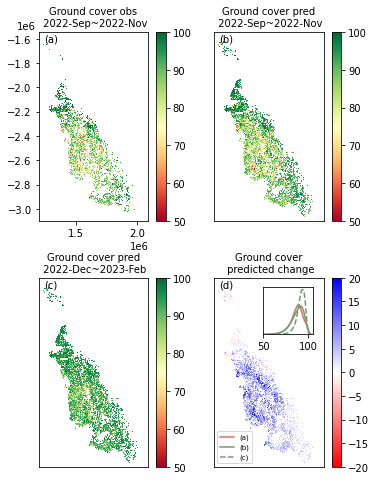

In [55]:
transform_pred = src.transform
str_last_season = '2022-Sep~2022-Nov'
str_next_season = '2022-Dec~2023-Feb'
meta_pred = src.meta
fig, axes = plt.subplots(2, 2, figsize = [6, 8])
ax1 = axes[0, 0]
ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes)
im1 = show(last_obs.squeeze(), transform=transform_pred, interpolation='nearest',
           vmin=50, vmax=100,  cmap='RdYlGn', ax=ax1)
ax1.set_title('Ground cover obs\n {}'.format(str_last_season), fontsize=10)
t = ax1.yaxis.get_offset_text()
t.set_x(-0.2)
plt.colorbar(im1.get_images()[0], ax=ax1)

ax2 = axes[0, 1]
ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes)
im2 = show(last_pred.squeeze(), transform=transform_pred, interpolation='nearest',
           vmin=50, vmax=100,  cmap='RdYlGn', ax=ax2)
plt.colorbar(im2.get_images()[0], ax=ax2)
ax2.set_title('Ground cover pred\n {}'.format(str_last_season), fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])
ax3 = axes[1, 0]
ax3.text(0.05, 0.95, '(c)', transform=ax3.transAxes)
im3 = show(new_pred.squeeze(), transform=transform_pred, interpolation='nearest',
           vmin=50, vmax=100,  cmap='RdYlGn', ax=ax3)
plt.colorbar(im3.get_images()[0], ax=ax3)
ax3.set_title('Ground cover pred\n {}'.format(str_next_season), fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])
ax4 = axes[1, 1]
ax4.text(0.05, 0.95, '(d)', transform=ax4.transAxes)
im4 = show(diff.squeeze(), transform=transform_pred, interpolation='nearest',
           vmin=-20, vmax=20,  cmap='bwr_r', ax=ax4)
ax4.set_title('Ground cover\n predicted change', fontsize=10)
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = ax4.inset_axes([0.45, 0.7, 0.45, 0.25])
sns.kdeplot(last_obs.squeeze().reshape(-1), ax=ax5, 
            linestyle='-',color='#d96f6f',label='(a)', gridsize=100, bw_adjust=3)
sns.kdeplot(last_pred.squeeze().reshape(-1).reshape(-1), ax=ax5, 
            linestyle='-', color='#729c6b',label='(b)', gridsize=100, bw_adjust=3)
sns.kdeplot(new_pred.squeeze().reshape(-1).reshape(-1), ax=ax5, 
            linestyle='--', color='#729c6b',label='(c)', gridsize=100, bw_adjust=3)
ax5.set_yticks([])
ax5.set_ylabel('')
ax5.set_xlim([50, 105])
ax5.set_xticks([50, 100])
ax5.legend(loc=3, bbox_to_anchor=(-1, -2.8, 0.5, 0.5),
          fontsize='x-small', markerscale=0.5)


fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.colorbar(im4.get_images()[0], ax=ax4)
#plt.savefig('Pred.jpg', dpi=300, bbox_inches='tight')

In [30]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("01-03-2019", "%d-%m-%Y")
end = datetime.datetime.strptime("01-03-2023", "%d-%m-%Y")
all_seasons = np.array([start + relativedelta(months=+x) for x in range(0, 51, 3)])

Text(0.5, 1.0, 'Scoring metrics')

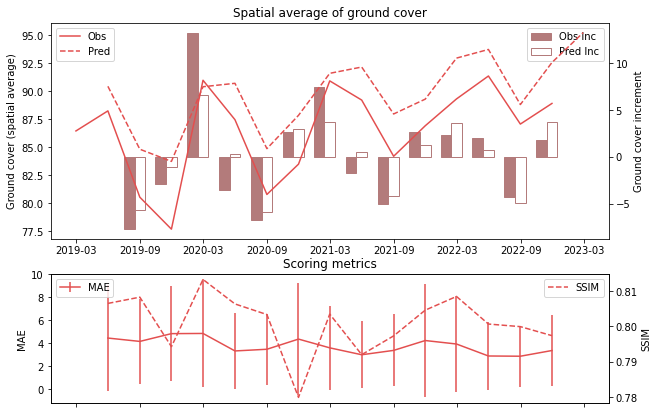

In [56]:
# Plot time series of predicted sequence
from matplotlib.dates import DateFormatter, MonthLocator
Obs_ts = np.nanmean(gc_obs, (1,2))
Obs_inc = Obs_ts[1:] - Obs_ts[:-1]
Pred_ts = np.nanmean(gc_pred, (1,2))
Pred_inc = Pred_ts[1:] - Pred_ts[:-1]
MAE_ts = np.nanmean(np.abs(gc_obs[1:16, :, :]-gc_pred[0:15, :, :]), (1, 2))
MAE_std = np.nanstd(np.abs(gc_obs[1:16, :, :]-gc_pred[0:15, :, :]), (1, 2))
SSIM_ts = [ssim(obs, pred) for (obs, pred) in zip(mosaic_obs[1:16, :, :], mosaic_pred[0:15, :, :])]
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1.2]})
ax0 = axes[0]
ax1 = ax0.twinx()
ax0.set_zorder(1) 
ax0.set_frame_on(False)
ax2 = axes[1]
ax3 = ax2.twinx()
ax0.plot(all_seasons[:16], Obs_ts, color='#e34f4f', linestyle='-',  label='Obs', zorder=1)
ax0.plot(all_seasons[1:17], Pred_ts, color='#e34f4f', linestyle='--',  label='Pred', zorder=2)
ax0.legend(loc=2)
ax0.set_ylabel('Ground cover (spatial average)')
bar_width = (all_seasons[1]-all_seasons[0])/3
ax1.bar(all_seasons[2:-1]-bar_width, Obs_inc[1:], width=bar_width, edgecolor='#b37b7b', facecolor='#b37b7b',
       label='Obs Inc', zorder=0)
ax1.bar(all_seasons[2:-1], Pred_inc[:-1], width=bar_width, edgecolor='#b37b7b', facecolor='None',
       label='Pred Inc', zorder=-1)
ax1.set_xticks(all_seasons[0:17:2]+relativedelta(days=1))
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax1.set_ylabel('Ground cover increment')
ax1.legend(loc=1)
ax1.set_title('Spatial average of ground cover')


ax2.errorbar(all_seasons[1:16], MAE_ts, yerr=MAE_std, color='#e34f4f', linestyle='-',  label='MAE')
ax2.legend(loc=2)
ax2.set_ylabel('MAE')
ax3.plot(all_seasons[1:16], SSIM_ts, color='#e34f4f', linestyle='--',  label='SSIM')
ax3.legend(loc=0)
ax3.set_ylabel('SSIM')
ax3.set_xticks(ax1.get_xticks())
ax3.set_xticklabels(ax1.get_xticklabels())
ax3.set_xlim(ax1.get_xlim())
ax3.set_title('Scoring metrics')